In [1]:
"""Temporary fix for importing modules from parent directory"""

import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from varitop.integrator import DelIntegrator as DI
from varitop.opti import Varitop

In [3]:
import sys
import numpy as np
import casadi as cs
import mediapy as media
from tqdm import tqdm
from time import sleep

In [4]:
import pinocchio as pin
import meshcat

In [5]:
from robot_descriptions.bolt_description import URDF_PATH

In [6]:
from darli.model import Functional
from darli.backend import CasadiBackend, JointType
from darli.backend.liecasadi.so3 import SO3
from darli.state_space import StateSpace
from darli.robots import biped
import casadi as cs

In [7]:
pinmodel, gpinmodel, cpinmodel = pin.buildModelsFromUrdf(URDF_PATH, package_dirs='/home/m8dotpie/.cache/robot_descriptions', geometry_types=[pin.GeometryType.VISUAL, pin.GeometryType.COLLISION], root_joint=pin.JointModelFreeFlyer())

In [8]:
pinmodel.nq, pinmodel.nv

(13, 12)

In [9]:
vis = pin.visualize.MeshcatVisualizer(pinmodel, gpinmodel, cpinmodel)

In [10]:
vis.initViewer(loadModel=True)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [11]:
vis.display(pin.neutral(pinmodel))

In [12]:
print(URDF_PATH)

/home/m8dotpie/.cache/robot_descriptions/example-robot-data/robots/bolt_description/robots/bolt.urdf


In [13]:
darli_model = biped(
    Functional,
    CasadiBackend,
    URDF_PATH,
    torso={'torso': 'base_link'},
    foots={'FL_FOOT': 'FL_FOOT', 'FR_FOOT': 'FR_FOOT'}, 
    root_joint=JointType.FREE_FLYER
)

In [14]:
darli_model.body('FL_FOOT').add_contact(contact_type='point')
darli_model.body('FL_FOOT').contact.add_cone(mu=0.2)
cwcl = darli_model.body('FL_FOOT').contact.cone.linear()

In [15]:
darli_model.body('FR_FOOT').add_contact(contact_type='point')
darli_model.body('FR_FOOT').contact.add_cone(mu=0.2)
cwcr = darli_model.body('FR_FOOT').contact.cone.linear()

In [16]:
darli_model.contact_qforce

Function(contact_qforce:(q[13],FL_FOOT[3],FR_FOOT[3])->(contact_qforce[12]) SXFunction)

In [17]:
nq = darli_model.nq
nv = darli_model.nv
nu = darli_model.nu
nq, nv, nu

(13, 12, 6)

In [18]:
di = DI(
    nq=nq,
    nu=nu,
    free_body=True,
    lagrangian=darli_model.lagrangian,
)

In [19]:
di.add_force(cs.vertcat(np.zeros(7), di.u))
di.add_constraint(di.q[3:7].T @ di.q[3:7] - 1)

In [20]:
darli_model.contact_qforce

Function(contact_qforce:(q[13],FL_FOOT[3],FR_FOOT[3])->(contact_qforce[12]) SXFunction)

In [21]:
nsteps = 100
dt = 0.01
step_length = 0.1
q_init = pin.neutral(pinmodel)

In [22]:
vp = Varitop(
    integrator=di,
    nsteps=nsteps,
    dt=dt,
    custom_dynamics=True
)

In [23]:
f = vp.problem.variable(3, nsteps)
f.shape

(3, 100)

In [24]:
from varitop.misc import quat_prod

In [25]:
del_res = vp.integrator.get_residual()

for i in range(1, nsteps):
    qforce = darli_model.contact_qforce(
        vp.q[:, i],
        f[:, i],
        np.zeros(3)
    )

    qft = qforce[:3]
    qrt = qforce[3:6]
    qrest = qforce[6:]
    qrt = 2 * quat_prod(vp.q[3:7, i], cs.vcat([qrt, 0]))
    qforce = cs.vertcat(qft, qrt, qrest, 0)
    vp.subject_to(
        vp.residual(i) - qforce == 0
    )

vp.subject_to(
    vp.q[:, 0] == vp.q[:, 1]
)

Stance constraints

In [26]:
# contact constraints

for i in range(1, nsteps):
    lb = np.full(3, -np.inf)
    ub = np.zeros(3)
    vp.bounded(
        lb, 
        cwcl[:3, :] @ f[:, i],
        ub
    )

    lb = 0
    ub = np.inf
    vp.bounded(
        lb,
        f[:, 2],
        ub
    )

In [27]:
# initial lfoot condition

lfoot = darli_model.body('FL_FOOT')
lfoot_init = lfoot.position(q_init)

vp.subject_to(
    lfoot.position(vp.q[:, 0]) - lfoot_init == 0
)

In [28]:
rfoot = darli_model.body('FR_FOOT')
rfoot_init = rfoot.position(q_init) + np.array([-step_length / 2, 0, 0])
rfoot_end = rfoot.position(q_init) + np.array([step_length / 2, 0, 0])

vp.subject_to(
    rfoot.position(vp.q[:, 0]) - rfoot_init == 0
)
vp.subject_to(
    rfoot.position(vp.q[:, -1]) - rfoot_end == 0
)

for i in range(nsteps):
    pos = rfoot.position(vp.q[:, i])
    vp.bounded(
        -0.5,
        pos[2],
        0
    )

In [42]:
rfoot_init, rfoot_end

(DM([-0.05, -0.1235, -0.4386]), DM([0.05, -0.1235, -0.4386]))

In [29]:
q_init = pin.neutral(pinmodel)

In [30]:
for i in range(0, nsteps):
    vp.set_initial(vp.q[:, i], q_init)

In [31]:
# Cost function

cost = 0

for i in range(1, nsteps):
    cost += vp.dt * (vp.u[:, i].T @ vp.u[:, i])

vp.set_cost(cost)

In [32]:
sol = vp.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    49301
Number of nonzeros in inequality constraint Jacobian.:     1988
Number of nonzeros in Lagrangian Hessian.............:    27045

Total number of variables............................:     2313
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1408
Total number of inequality c

RuntimeError: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:157:
.../casadi/core/optistack_internal.cpp:998: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'Maximum_Iterations_Exceeded'

In [33]:
qs = vp.problem.debug.value(vp.q)
qs.shape

(13, 101)

In [34]:
rfoot.position(qs[:, 0]), rfoot.position(qs[:, -1])

(DM([-0.05, -0.1235, -0.4386]), DM([0.0500002, -0.1235, -0.4386]))

In [35]:
rfoot_init, rfoot_end

(DM([-0.05, -0.1235, -0.4386]), DM([0.05, -0.1235, -0.4386]))

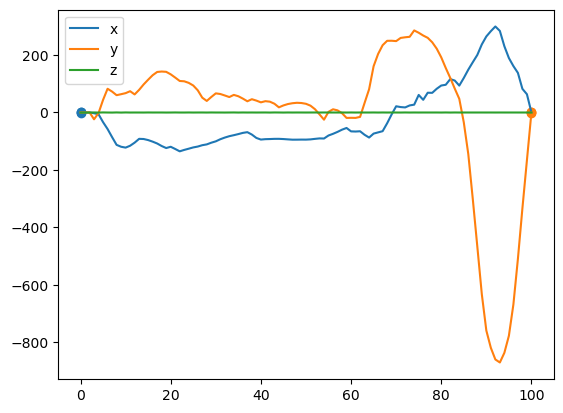

In [36]:
import matplotlib.pyplot as plt

rfootpos = np.array([rfoot.position(q) for q in qs.T]).squeeze()

plt.plot(rfootpos, label=['x', 'y', 'z'])
plt.scatter(np.zeros(3), np.array(rfoot_init))
plt.scatter(np.full(3, 100), np.array(rfoot_end))

plt.legend()
plt.show()

In [37]:
pin.neutral(pinmodel), qs[:, 0]

(array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
 array([ 0.01620355, -0.14126739, -0.11284596,  0.16667817, -0.55961035,
         0.10812341,  0.69059248,  0.26951083,  1.01797715, -0.00832578,
         1.26943569,  1.89965796, -0.77240849]))

In [38]:
np.linalg.norm(qs[3:7, 0])

0.9107985521689118

In [43]:
rfoot_end, darli_model.body('FR_FOOT').position(qs[:, -1])

(DM([0.05, -0.1235, -0.4386]), DM([0.0500002, -0.1235, -0.4386]))

In [39]:
q_init = pin.neutral(pinmodel)
move = np.zeros(nq)
move[3] = np.cos(np.pi / 4)
move[6] = np.sin(np.pi / 4)

In [44]:
vis.display(q_init)

In [40]:
# vis.display(q_init + move)
sleep(2)
for i in range(len(qs.T)):
    vis.display(qs[:, i])

    sleep(dt * 10)